In [1]:
# general imports 
import datetime
import geopandas as gpd
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import math
import numpy as np
import os
import pandas as pd
import shapely 
import sys
import xarray as xr
from rasterio import plot
from osgeo import gdal

In [23]:
input_path = "C:\\Users\\nicsw\\Documents\\Nave_Projects\\retro_creating_pdfs\\granules\\76734698-59b1-463e-929f-d1e5a98d5b2a"

btm_block = None # bottom
wth_block = None # weather
twr_block = None # top at work resolution
thr_block = None # top at high resolution
sls_block = None # soil properties
ssm_block = None # surface soil moisture

for (root,dirs,files) in os.walk(input_path, topdown=True):
    for file in files:
        print(file)
        if 'SSMCV4' in file :
            ssm_block = xr.open_dataset(os.path.join(input_path, file))
        if 'SGR2' in file :
            sls_block = xr.open_dataset(os.path.join(input_path, file))
        if 'FBTM' in file :
            btm_block = xr.open_dataset(os.path.join(input_path, file))
        if 'FW1D' in file :
            wth_block = xr.open_dataset(os.path.join(input_path, file))
        if 'FTOP' in file :
            if 'HRes' in file :
                thr_block = xr.open_dataset(os.path.join(input_path, file))
            if 'WRes' in file :
                twr_block = xr.open_dataset(os.path.join(input_path, file))  

FBTM_76734698-59b1-463e-929f-d1e5a98d5b2a_2024-11-07_71742.227875_WRes.nc
FTOP_76734698-59b1-463e-929f-d1e5a98d5b2a_2024-11-07_71742.227875_WRes.nc
FTOP_76734698-59b1-463e-929f-d1e5a98d5b2a_2024-11-07_71742.233741_HRes.nc
FW1D_76734698-59b1-463e-929f-d1e5a98d5b2a_2024-11-07_71742.238358.nc
SGR250_76734698-59b1-463e-929f-d1e5a98d5b2a_2024-11-07_71742.227875_WRes.nc


In [7]:
#input_dir = "C:\\Users\\nicsw\\Documents\\Nave_Projects\\retro_creating_pdfs\\granules\\76734698-59b1-463e-929f-d1e5a98d5b2a"

def create_granule_dict(input_dir):
    input_path = input_dir
    granule = dict({
            'btm1_block' : None, # bottom
            'wth1_block' : None, # weather
            'twr1_block' : None, # top at work resolution
            'thr1_block' : None, # top at high resolution
            'soi1_block' : None, # soil

            'btm1_path' : None, # bottom
            'wth1_path' : None, # weather
            'twr1_path' : None, # top at work resolution
            'thr1_path' : None, # top at high resolution
            'soi1_path' : None, # tsoil
    })

    for (root,dirs,files) in os.walk(input_path, topdown=True):
        for file in files:
            #print(file)
            if 'SGR2' in file :
                granule['soi1_path'] = os.path.join(input_path,file)
                granule['soi1_block'] = xr.open_dataset(os.path.join(input_path, file))
            if 'FBTM' in file :
                granule['btm1_path'] = os.path.join(input_path,file)
                granule['btm1_block'] = xr.open_dataset(os.path.join(input_path, file))
            if 'FW1D' in file :
                granule['wth1_path'] = os.path.join(input_path,file)
                granule['wth1_block'] = xr.open_dataset(os.path.join(input_path, file))
                fsd =  granule['wth1_block'].attrs['Forecast_transit_date']
            if 'FTOP' in file :
                if 'HRes' in file :
                    granule['thr1_path'] = os.path.join(input_path,file)
                    granule['thr1_block'] = xr.open_dataset(os.path.join(input_path, file))
                if 'WRes' in file :
                    granule['twr1_path'] = os.path.join(input_path,file)
                    granule['twr1_block'] = xr.open_dataset(os.path.join(input_path, file))
    return granule

In [8]:
granule_dict = create_granule_dict("C:\\Users\\nicsw\\Documents\\Nave_Projects\\retro_creating_pdfs\\granules\\76734698-59b1-463e-929f-d1e5a98d5b2a")

In [9]:
granule_dict

{'btm1_block': <xarray.Dataset>
 Dimensions:          (time: 187, lat: 3, lon: 3, depth: 6)
 Coordinates:
   * time             (time) datetime64[ns] 2023-11-02 2023-11-03 ... 2024-05-06
   * lat              (lat) float64 19.9 19.89 19.89
   * lon              (lon) float64 -101.0 -101.0 -101.0
   * depth            (depth) int64 5 15 30 60 100 200
 Data variables: (12/15)
     trnsp            (time, lat, lon) float64 ...
     rtzn_dp          (time, lat, lon) float32 ...
     wshort_risk      (time, lat, lon) float64 ...
     wexcess_risk     (time, lat, lon) float64 ...
     sm_05_cm_est     (time, lat, lon) float64 ...
     sm_05_cm_sgm     (time, lat, lon) float64 ...
     ...               ...
     sm_30_cm_sgm     (time, lat, lon) float64 ...
     sm_60_cm_est     (time, lat, lon) float64 ...
     sm_60_cm_sgm     (time, lat, lon) float64 ...
     assim_rz_sm_est  (time, lat, lon) float64 ...
     assim_rz_sm_sgm  (time, lat, lon) float64 ...
     wlp              (time, lat, l

In [5]:
# forecast transit date 
forecast_transit_date = pd.to_datetime(granule_dict['wth1_block'].attrs['Forecast_transit_date'])
up_to_date = forecast_transit_date
print(forecast_transit_date)


2024-04-28 00:00:00


In [15]:
twr_block2 = granule_dict['twr1_block']

<module 'matplotlib.pyplot' from 'C:\\Users\\nicsw\\anaconda3\\envs\\nave23\\lib\\site-packages\\matplotlib\\pyplot.py'>

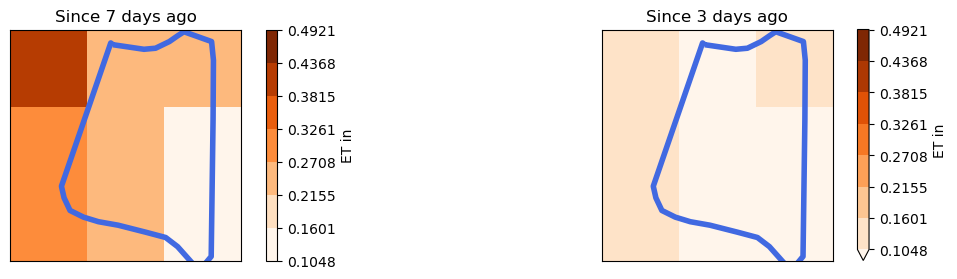

In [16]:
build_evapotranspiration_map(forecast_transit_date, twr_block2)

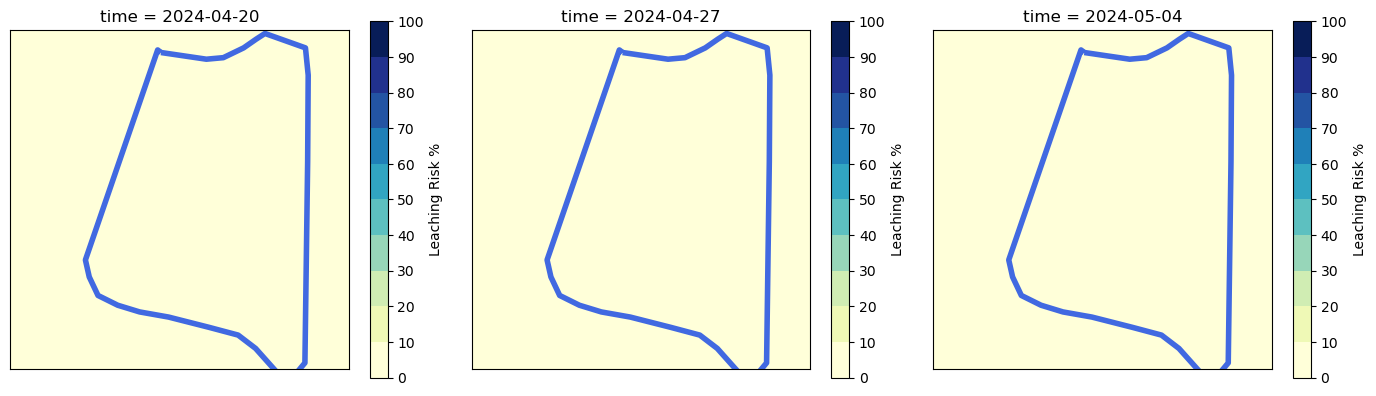

In [9]:
###################################################################################################
#  make Leaching maps 
###################################################################################################


#standard
up_to_date = forecast_transit_date - pd.Timedelta('1 days') 

# for eye candy
past_1d = up_to_date 
past_7d = up_to_date - pd.Timedelta('7 days') 
futr_7d = up_to_date + pd.Timedelta('7 days') 

leach_risk_p1d_da = btm_block.wexcess_risk.sel(time = past_1d)
leach_risk_p7d_da = btm_block.wexcess_risk.sel(time = past_7d)
leach_risk_f7d_da = btm_block.wexcess_risk.sel(time = futr_7d)

etlabel ="Leaching Risk %"

# Prepare the figure
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
# Color levels
levels=np.array([q for q in range(0,11)])*10

# Plot data
leach_risk_p7d_da.plot(ax=ax1, cmap = plt.cm.YlGnBu, levels=levels, cbar_kwargs={"label": etlabel, "ticks": levels, "spacing": "proportional"})
leach_risk_p1d_da.plot(ax=ax2, cmap = plt.cm.YlGnBu, levels=levels, cbar_kwargs={"label": etlabel, "ticks": levels, "spacing": "proportional"})
leach_risk_f7d_da.plot(ax=ax3, cmap = plt.cm.YlGnBu, levels=levels, cbar_kwargs={"label": etlabel, "ticks": levels, "spacing": "proportional"})

                       
geom = shapely.wkt.loads(twr_block.aoi)
g = gpd.GeoSeries([geom])
g.plot(ax=ax1, facecolor='none', edgecolor='royalblue',linewidth=4)
g.plot(ax=ax2, facecolor='none', edgecolor='royalblue',linewidth=4)
g.plot(ax=ax3, facecolor='none', edgecolor='royalblue',linewidth=4)

ax1.xaxis.set_major_locator(ticker.NullLocator())
ax1.yaxis.set_major_locator(ticker.NullLocator())
ax2.xaxis.set_major_locator(ticker.NullLocator())
ax2.yaxis.set_major_locator(ticker.NullLocator())
ax3.xaxis.set_major_locator(ticker.NullLocator())
ax3.yaxis.set_major_locator(ticker.NullLocator())
ax1.set(xlabel=None)
ax1.set(ylabel=None)
ax2.set(xlabel=None)
ax2.set(ylabel=None)
ax3.set(xlabel=None)
ax3.set(ylabel=None)

#ax1.title.set_text("Week ago")
#ax2.title.set_text("Today")
#ax3.title.set_text("Next week")


# Show plots,
plt.tight_layout()


In [20]:
btm2_block = granule_dict['btm1_block']


#build_leaching_map(forecast_transit_date, btm2_block)

None


Text(2024-04-28 00:00:00, 0.5389763779527559, ' Forecast')

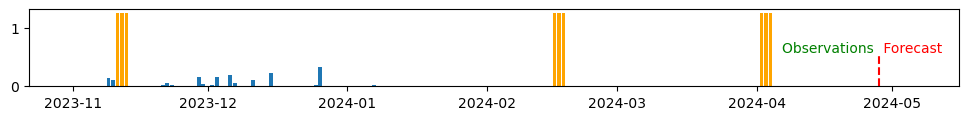

In [10]:
###################################################################################################
#  make precipitation / irrigation time series 
###################################################################################################


precip_array = wth_block.Precip_m_d.data #* 100.0 # to mm Note it has to be 100
precip_array = precip_array.reshape([precip_array.shape[0]],)/25.4
precip_df = pd.DataFrame({'precip': precip_array.tolist()},
                   index=wth_block.Precip_m_d.time.values)    

#Plotting:
plt.figure(figsize=(12,1))
date = precip_df.index.to_list()
plt.bar(date, precip_df['precip'].tolist())


# irrigation part

if 'irrigtn_mm_d' in list(twr_block.keys()):
    irr_array = twr_block.irrigtn_mm_d.isel(lat=0,lon=0).data
    irr_array = irr_array.reshape([irr_array.shape[0]],)/25.4
    irr_df = pd.DataFrame({'irrigtn': irr_array.tolist()},
                   index=twr_block.irrigtn_mm_d.time.values)
    plt.bar(date, irr_df['irrigtn'].tolist(), color = 'orange')
    
# forecast split bar 
plt.plot([forecast_transit_date, forecast_transit_date], 
         [0 , precip_df['precip'].max()], color = 'red', ls= '--')
plt.text(forecast_transit_date, precip_df['precip'].max(), 'Observations ',
        verticalalignment='bottom', horizontalalignment='right',
        color='green', fontsize=10)
plt.text(forecast_transit_date, precip_df['precip'].max(), ' Forecast',
        verticalalignment='bottom', horizontalalignment='left',
        color='red', fontsize=10)


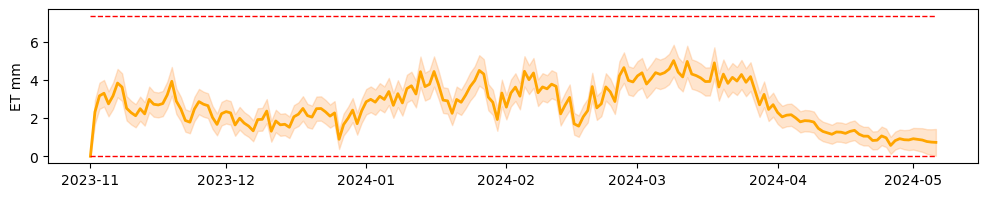

In [11]:
###################################################################################################
#  make ET time series with signas
###################################################################################################
# set first to 0 always 
twr_block.ETA_est_mm_day.loc[dict(time=twr_block.time.min())] = 0
twr_block.ETA_sgm_mm_day.loc[dict(time=twr_block.time.min())] = 0
# then as usual
eta_est_arr = twr_block.ETA_est_mm_day.median(dim =['lat', 'lon'])
eta_sgm_arr = twr_block.ETA_sgm_mm_day.median(dim =['lat', 'lon'])
# imperial units 
#eta_est_arr = eta_est_arr/25.4
#eta_sgm_arr = eta_sgm_arr/25.4


eta_est_df = pd.DataFrame({0: eta_est_arr.data.tolist()},
                    index=eta_est_arr.time.values)
eta_sig_df = pd.DataFrame({0: eta_sgm_arr.data.tolist()},
                   index=eta_sgm_arr.time.values)
under_line     = (eta_est_df-eta_sig_df)[0]
over_line      = (eta_est_df+eta_sig_df)[0]
under_line[under_line < 0] = 0
etlabel ="ET mm"
i2xw = eta_sig_df*0+24.5*0.3 # 2 week line metric
# etlabel ="ET in" imperial
#i2xw = eta_sig_df*0+03 # 2 week line imperial
#Plotting:
plt.figure(figsize=(12,2))
plt.ylabel(etlabel)
plt.plot(eta_est_df, color='orange', linewidth=2) #mean curve.
plt.fill_between(eta_sig_df.index, under_line, over_line, color='C1', alpha=.2) #std curves.
plt.plot(i2xw, linewidth=1, color='r', linestyle='dashed' ) 
plt.plot(i2xw*0, linewidth=1, color='r', linestyle='dashed', ) 



In [30]:
granule_dict['twr1_block']

<xarray.Dataset>
Dimensions:         (time: 188, lat: 3, lon: 3)
Coordinates:
  * time            (time) datetime64[ns] 2023-11-01 2023-11-02 ... 2024-05-06
  * lat             (lat) float64 19.9 19.89 19.89
  * lon             (lon) float64 -101.0 -101.0 -101.0
Data variables:
    KC              (time, lat, lon) float32 ...
    LAI             (time, lat, lon) float32 ...
    AWL             (time, lat, lon) float32 ...
    ETA_est_mm_day  (time, lat, lon) float32 ...
    ETA_sgm_mm_day  (time, lat, lon) float32 ...
    irrigtn_mm_d    (time, lat, lon) float32 ...
    Fr_Cover        (time, lat, lon) float32 ...
Attributes:
    Forecast_transit_date:      2024-04-28
    uid:                        76734698-59b1-463e-929f-d1e5a98d5b2a
    aoi:                        POLYGON ((-101.03525554413154 19.895824324665...
    crop:                       soybean
    Curent_et_mm_day:           0.84997773
    Current_et_risk_category:   0
    Forecast_et_mm_day:         0.7440531
    Forecast_et_risk_category:  0
    Crop_type:                  soybean
    field_uid:                  76734698-59b1-463e-929f-d1e5a98d5b2a
    NPV:                        NAVE-TOP_V1.3

<module 'matplotlib.pyplot' from 'C:\\Users\\nicsw\\anaconda3\\envs\\nave23\\lib\\site-packages\\matplotlib\\pyplot.py'>

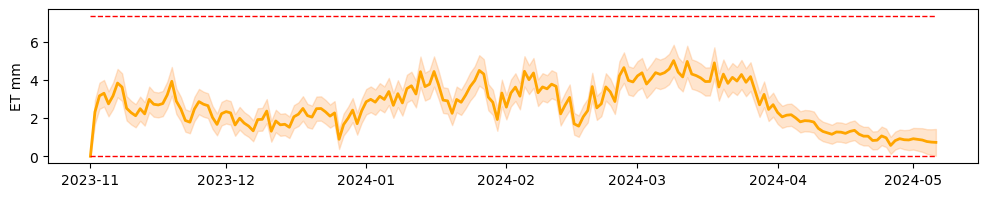

In [31]:
et_time_series_with_sigmas(granule_dict['twr1_block'])